# Setting things up and plotting for tests for multiple tiles in FEEBeam

First up, here are all the module loads you need to do. Define some constants as well while we're at it

In [1]:
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from copy import deepcopy
import erfa
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mwa_hyperbeam
from subprocess import call

print(mwa_hyperbeam.__version__)

D2R = np.pi / 180.0
VELC = 299792458.0
MWA_LAT = -26.7033194444
MWA_LAT_RAD = MWA_LAT * D2R

lst_rad = 74.15019835*D2R
lst_deg = lst_rad / D2R

zenith_delays = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
off_zenith1_delays = [0, 4, 8, 12, 0, 4, 8, 12, 0, 4, 8, 12, 0, 4, 8, 12]
off_zenith2_delays = [0, 2, 4, 8, 2, 4, 8, 12, 4, 8, 12, 16, 8, 12, 16, 20]

all_delays = [zenith_delays, off_zenith1_delays, off_zenith2_delays]
all_delay_names = ["zenith", "offzen1", "offzen2"]
freqs = [100e+6, 150e+6, 200e+6]

0.10.1


In [2]:
def add_colourbar(fig=None,ax=None,im=None,label=False,top=False):
    """
    Adds a colourbar (colorbar, fine) in a nice way to a subplot

    Parameters
    ----------
    fig : matplotlib.pyplot.figure instance
        The figure that the plot lives on
    ax : matplotlib.pyplot.figure.add_subplot instance
        The axis to append a colorbar to
    im : ax.imshow output
        The output of imshow to base the colourbar on
    label : string
        Optional - add a label to the colorbar
    top : Bool
        Optional - put the colorbar above the axis instead of to the right
    """

    divider = make_axes_locatable(ax)
    if top == True:
        cax = divider.append_axes("top", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax = cax,orientation='horizontal')
        cax.xaxis.set_ticks_position('top')
        cax.xaxis.set_label_position('top')
    else:
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax = cax)
    if label:
        cbar.set_label(label)


# Now you need to run `ctest` to generate test outputs

# Plotting outputs
Here be some functions to load up `ctest` outputs, and then plot them

In [3]:
def load_data(filename):
    """Load the data out of the C testing code into complex arrays"""
    azs, zas, gx_re, gx_im, Dx_re, Dx_im, Dy_re, Dy_im, gy_re, gy_im, freqs = np.loadtxt(filename, unpack=True)

    gx = gx_re + gx_im*1j
    Dx = Dx_re + Dx_im*1j
    Dy = Dy_re + Dy_im*1j
    gy = gy_re + gy_im*1j

    return azs, zas, gx, Dx, Dy, gy, freqs

def plot_jones_square(azs, zas, gx, Dx, Dy, gy, plot_freqs, filename, tag='MWA_analy',
                      num_freqs=1, num_times=1, num_tiles=1, limits=True,
                      nside=101):
    """Take the data saved by the C testing code, convert into
    2D arrays and plot with imshow. Plot the gains and leakages
    as well as the linear Stokes pols. saves into the 'plots' dir."""
    outname = filename.split('/')[-1].split('_')[-1]

    num_comps = int(len(azs) / (num_freqs*num_times*num_tiles))
    
    print('num_comps', num_comps)

    for tile in range(num_tiles):
        for time in range(num_times):
            for freq_ind in range(num_freqs):
            # for freq_ind in range(1):
                freq = plot_freqs[freq_ind]

                # low = time*num_freqs*num_comps + freq_ind*num_comps
                low = tile*num_times*num_freqs*num_comps + time*num_freqs*num_comps + freq_ind*num_comps
                high = low + num_comps
                
                print(low, high)

                fig, axs = plt.subplots(2, 2, figsize=(12, 12))

                this_gx = gx[low:high]
                this_Dx = Dx[low:high]
                this_Dy = Dy[low:high]
                this_gy = gy[low:high]

                this_gx.shape = (nside, nside)
                this_Dx.shape = (nside, nside)
                this_Dy.shape = (nside, nside)
                this_gy.shape = (nside, nside)

                im1 = axs[0,0].imshow(this_gx.real, origin='lower')
                im2 = axs[0,1].imshow(this_Dx.real, origin='lower')
                im3 = axs[1,0].imshow(this_Dy.real, origin='lower')
                im4 = axs[1,1].imshow(this_gy.real, origin='lower')

                ims = [im1, im2, im3, im4]

                for im, ax in zip(ims, axs.flatten()):
                    add_colourbar(im=im, ax=ax, fig=fig)

                axs[0,0].set_title('Real gx')
                axs[0,1].set_title('Real Dx')
                axs[1,0].set_title('Real Dy')
                axs[1,1].set_title('Real gy')
                #
                for ax in axs.flatten():
                    ax.set_yticks([])
                    ax.set_xticks([])

                savename = f'plots/jones_{tag}_gains_nside{nside:d}_tile{tile:03d}t{time:02d}_f{freq/1e+6:.3f}MHz.png'
                print(savename)
                fig.savefig(savename,bbox_inches='tight')
                plt.show()
                plt.close()


                fig, axs = plt.subplots(2, 2, figsize=(12, 12))

                xx = this_gx*np.conjugate(this_gx) + this_Dx*np.conjugate(this_Dx)
                xy = this_gx*np.conjugate(this_Dy) + this_Dx*np.conjugate(this_gy)
                yx = this_Dy*np.conjugate(this_gx) + this_gy*np.conjugate(this_Dx)
                yy = this_gy*np.conjugate(this_gy) + this_Dy*np.conjugate(this_Dy)
                
                print("shapes sucka", xx.shape, xy.shape, yx.shape, yy.shape)

                print(np.max(np.abs(xx)), np.max(np.abs(yy)))
                
                if limits:
                    vmin_xx = vmin_yy = 0.0
                    vmax_xx = vmax_yy = 0.2
                else:
                    vmin_xx = np.real(xx).min()
                    vmax_xx = np.real(xx).max()
                    vmin_yy = np.real(yy).min()
                    vmax_yy = np.real(yy).max()
                

                im1 = axs[0,0].imshow(np.real(xx), origin='lower',
                                    vmin=vmin_xx,vmax=vmax_xx)
                im2 = axs[0,1].imshow(np.real(xy), origin='lower')# ,vmin=0,vmax=0.3)
                im3 = axs[1,0].imshow(np.real(yx), origin='lower')# ,vmin=0,vmax=0.3)
                im4 = axs[1,1].imshow(np.real(yy), origin='lower',
                                    vmin=vmin_yy,vmax=vmax_yy)

                ims = [im1, im2, im3, im4]

                for im, ax in zip(ims, axs.flatten()):
                    add_colourbar(im=im, ax=ax, fig=fig)

                axs[0,0].set_title('XX')
                axs[0,1].set_title('XY')
                axs[1,0].set_title('YX')
                axs[1,1].set_title('YY')
                #
                for ax in axs.flatten():
                    ax.set_yticks([])
                    ax.set_xticks([])

                savename = f'plots/linear_pol_{tag}_gains_nside{nside:d}_tile{tile:03d}t{time:02d}_f{freq/1e+6:.3f}MHz.png'
                print(savename)
                fig.savefig(savename,bbox_inches='tight')
                # plt.show()
                plt.close()

# MWA FEE plots
Let's plot up a bunch of pointings and frequencies, check everything is happy. There should be three frequencies and two time steps for each combination of delays and central frequency. Each central freq was run with three fine frequencies that are so similar, should return the same values. They are testing with the C code, but good to plot them up to see that they make sense on the sky

../../../build/cmake_testing/GPU_or_C_code/primary_beam/hyperbeam_zenith_200_multiants_rot_double.txt
num_comps 2601
0 2601
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile000t00_f199.600MHz.png


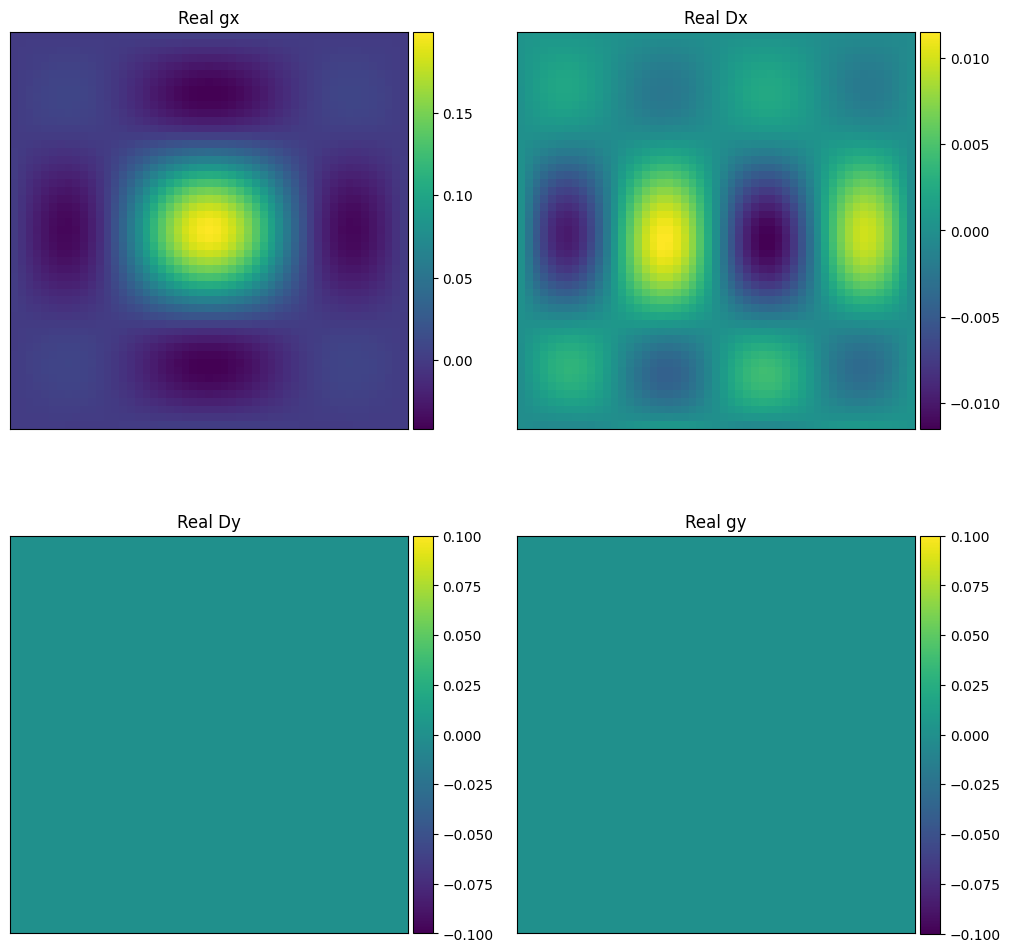

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
0.040000002468927764 0.0
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile000t00_f199.600MHz.png
2601 5202
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile000t00_f200.000MHz.png


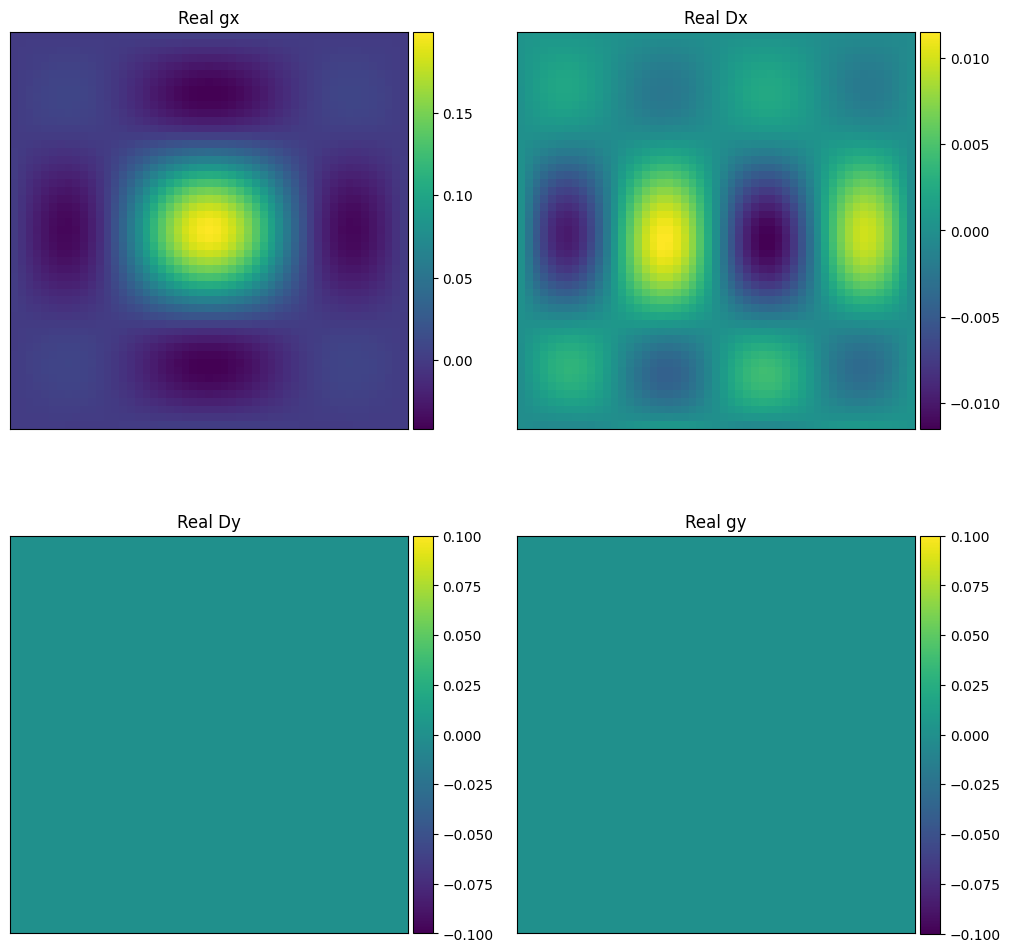

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
0.040000002468927764 0.0
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile000t00_f200.000MHz.png
5202 7803
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile000t00_f200.040MHz.png


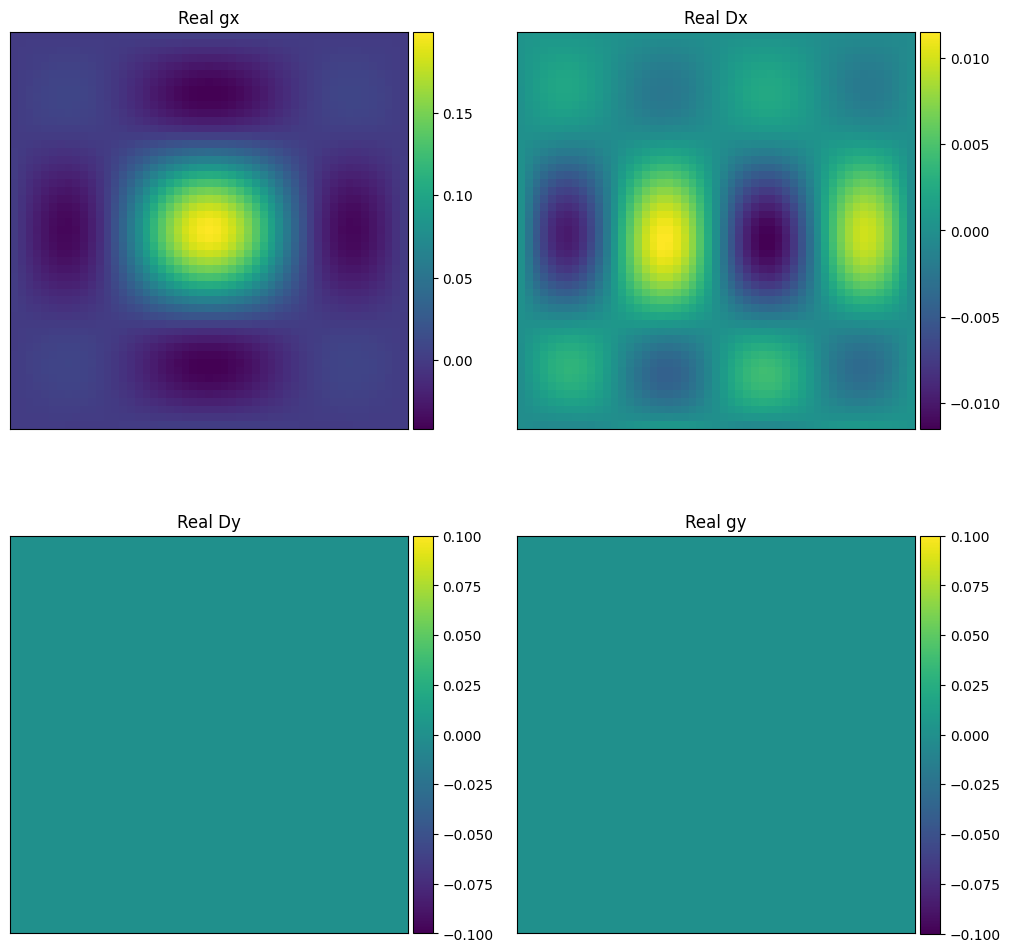

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
0.040000002468927764 0.0
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile000t00_f200.040MHz.png
7803 10404
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile000t01_f199.600MHz.png


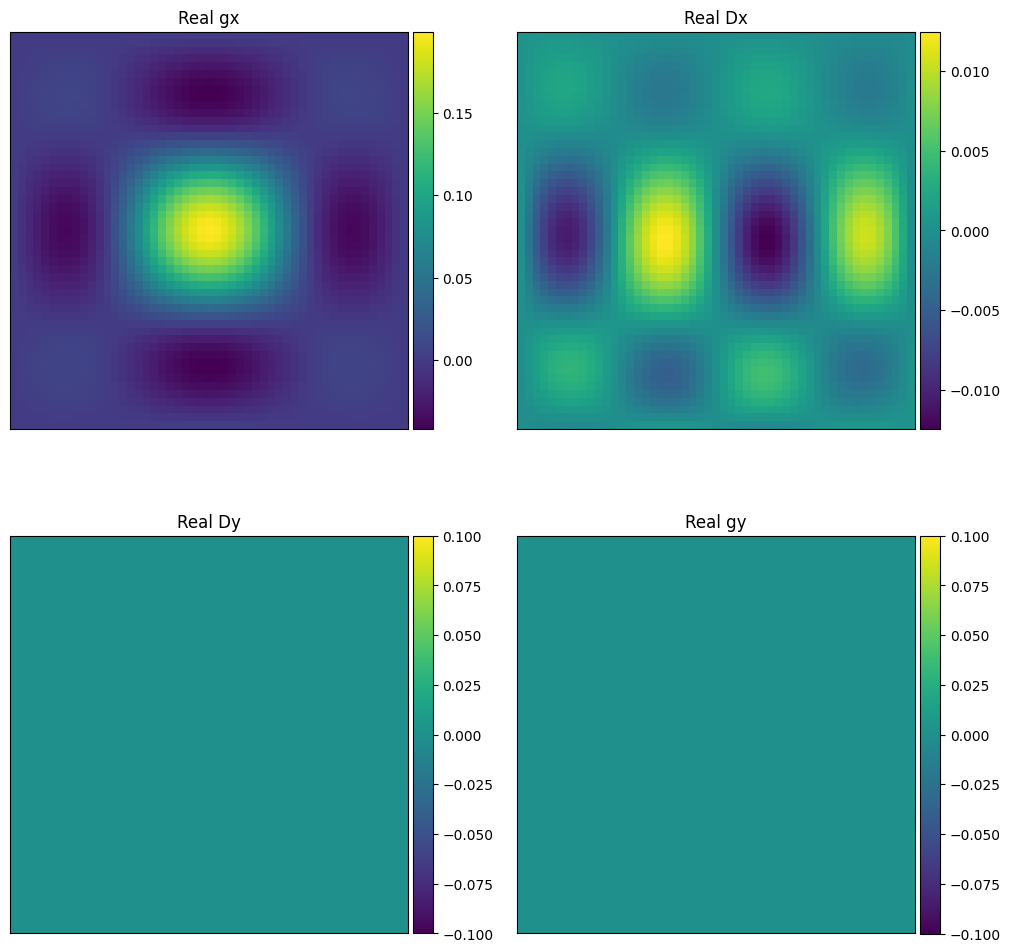

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
0.040000002468927764 0.0
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile000t01_f199.600MHz.png
10404 13005
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile000t01_f200.000MHz.png


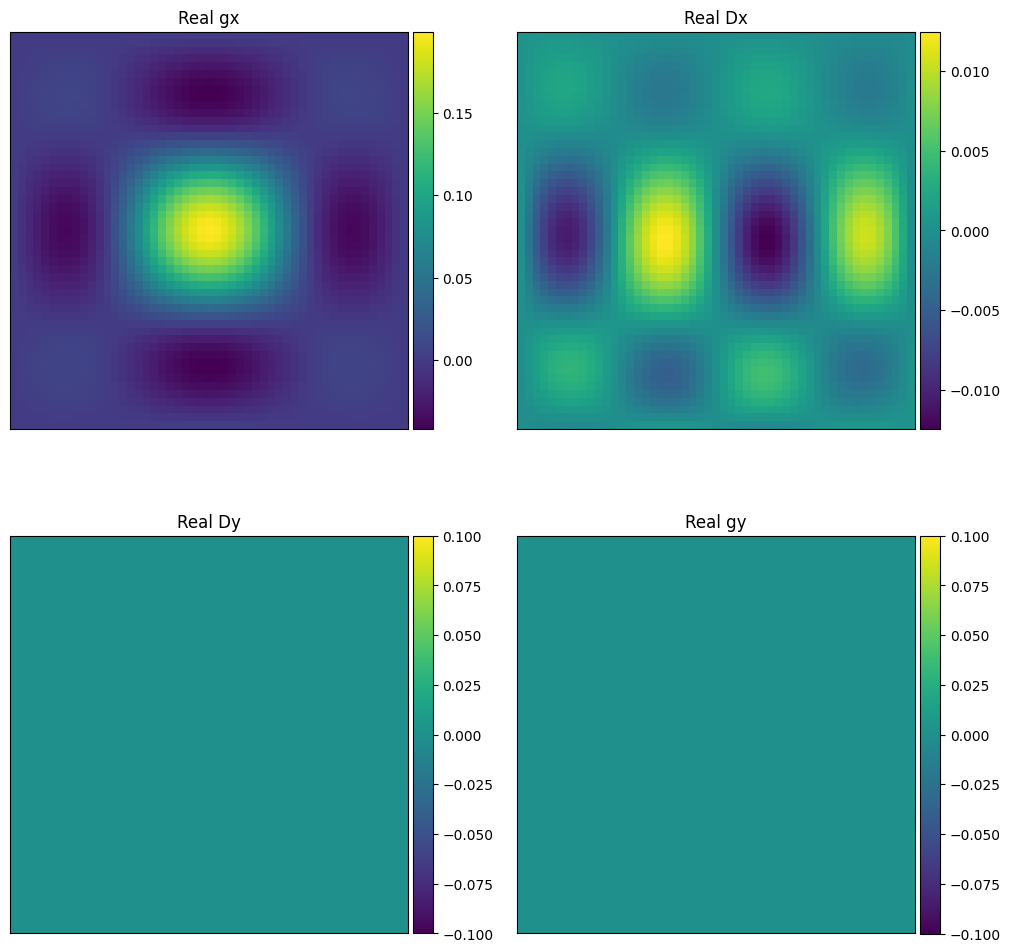

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
0.040000002468927764 0.0
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile000t01_f200.000MHz.png
13005 15606
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile000t01_f200.040MHz.png


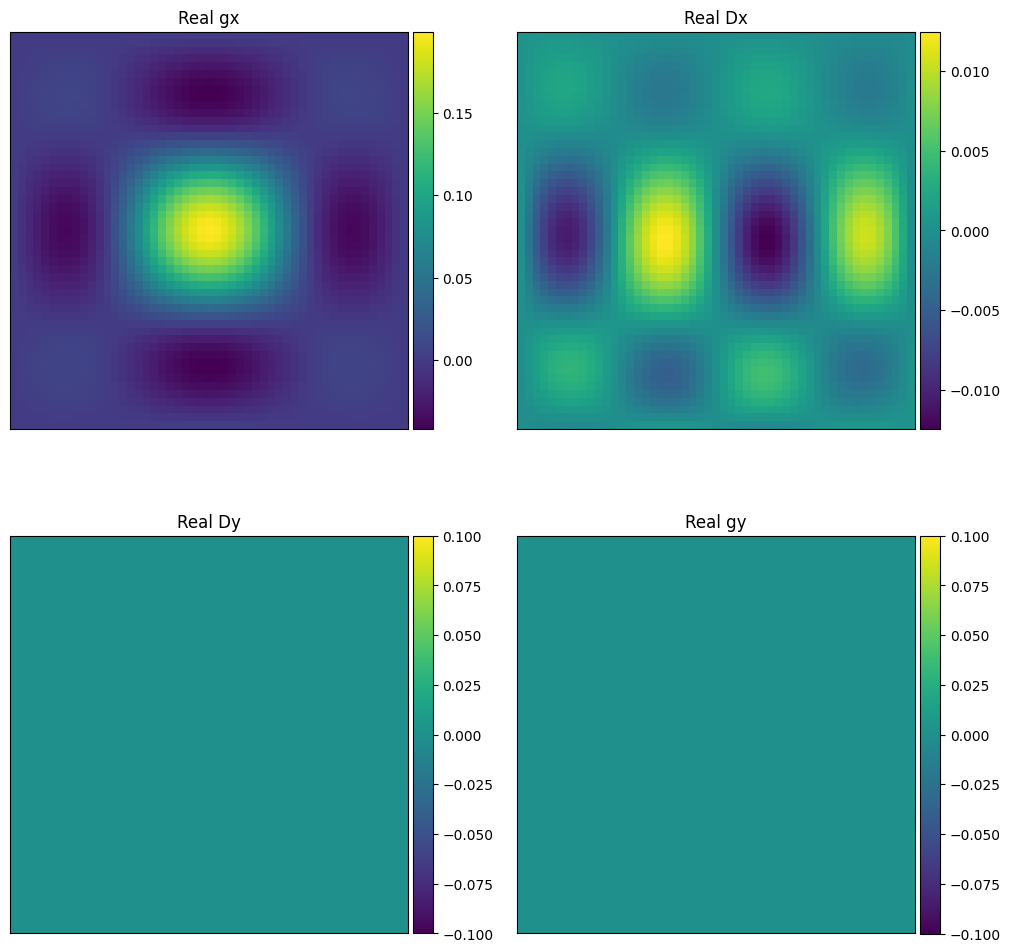

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
0.040000002468927764 0.0
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile000t01_f200.040MHz.png
15606 18207
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile001t00_f199.600MHz.png


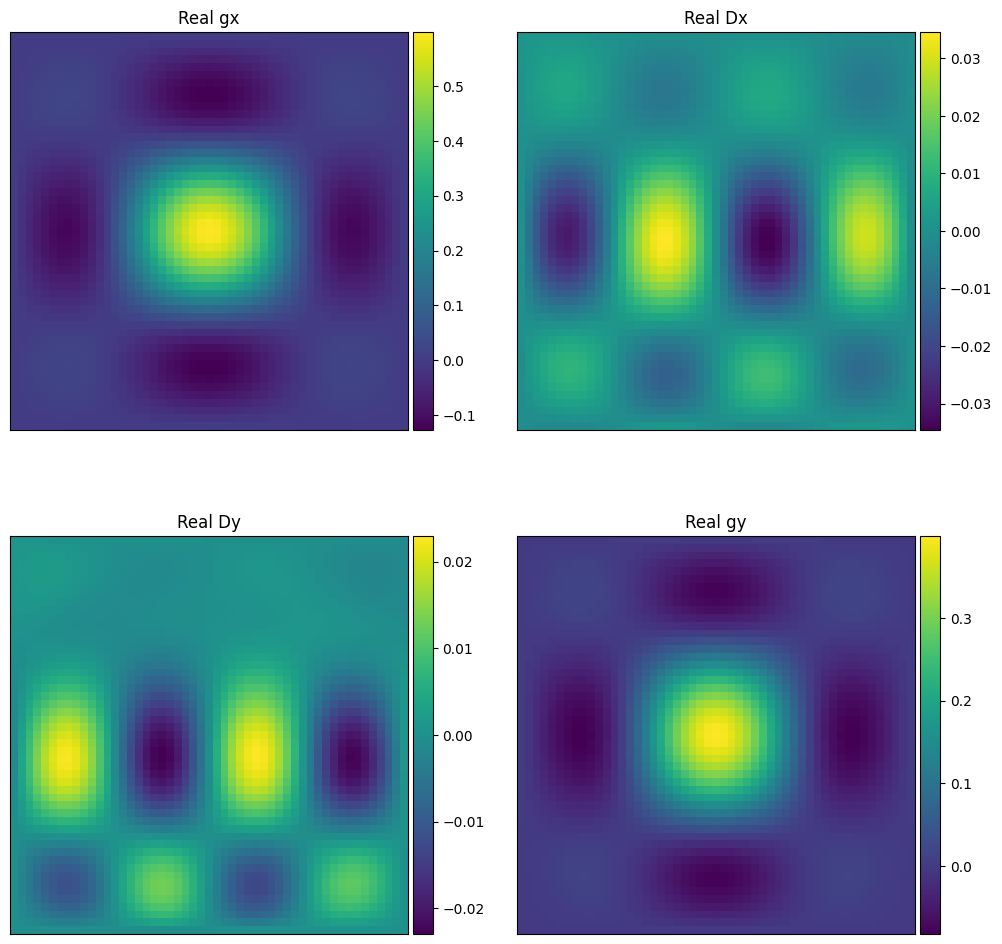

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
0.36000002222043886 0.16000001044474385
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile001t00_f199.600MHz.png
18207 20808
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile001t00_f200.000MHz.png


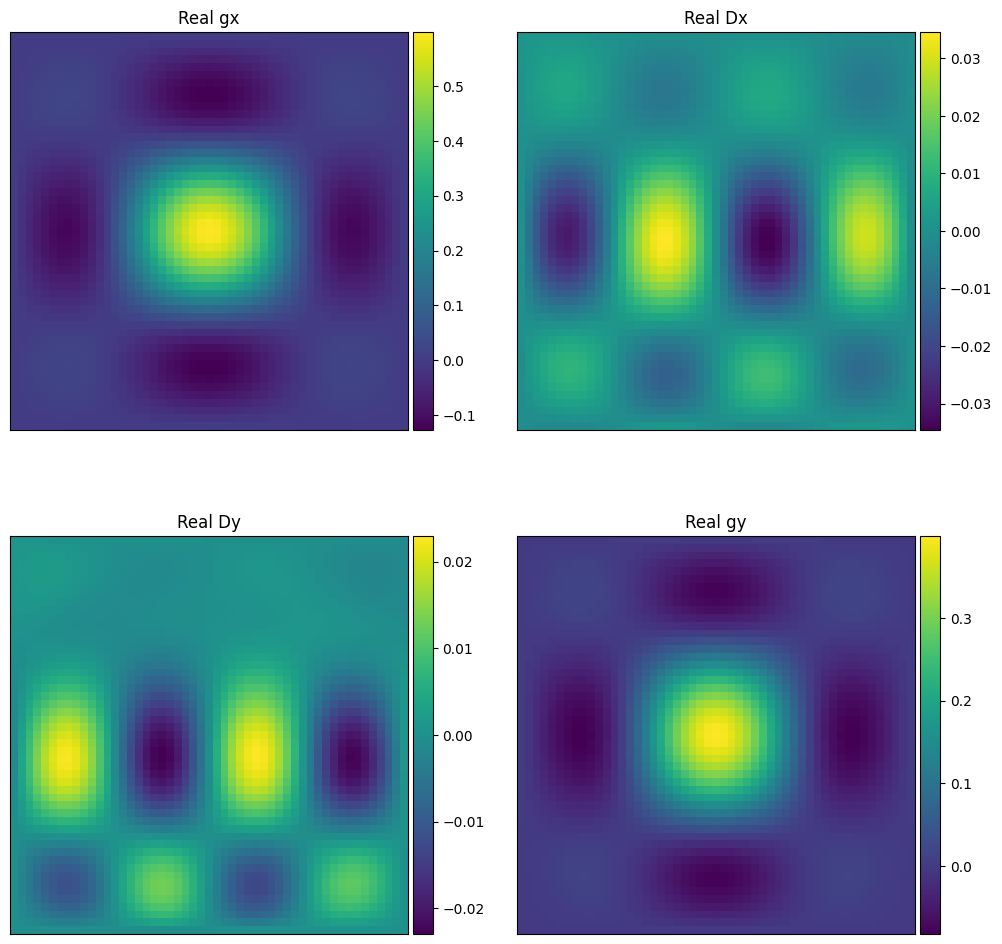

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
0.36000002222043886 0.16000001044474385
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile001t00_f200.000MHz.png
20808 23409
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile001t00_f200.040MHz.png


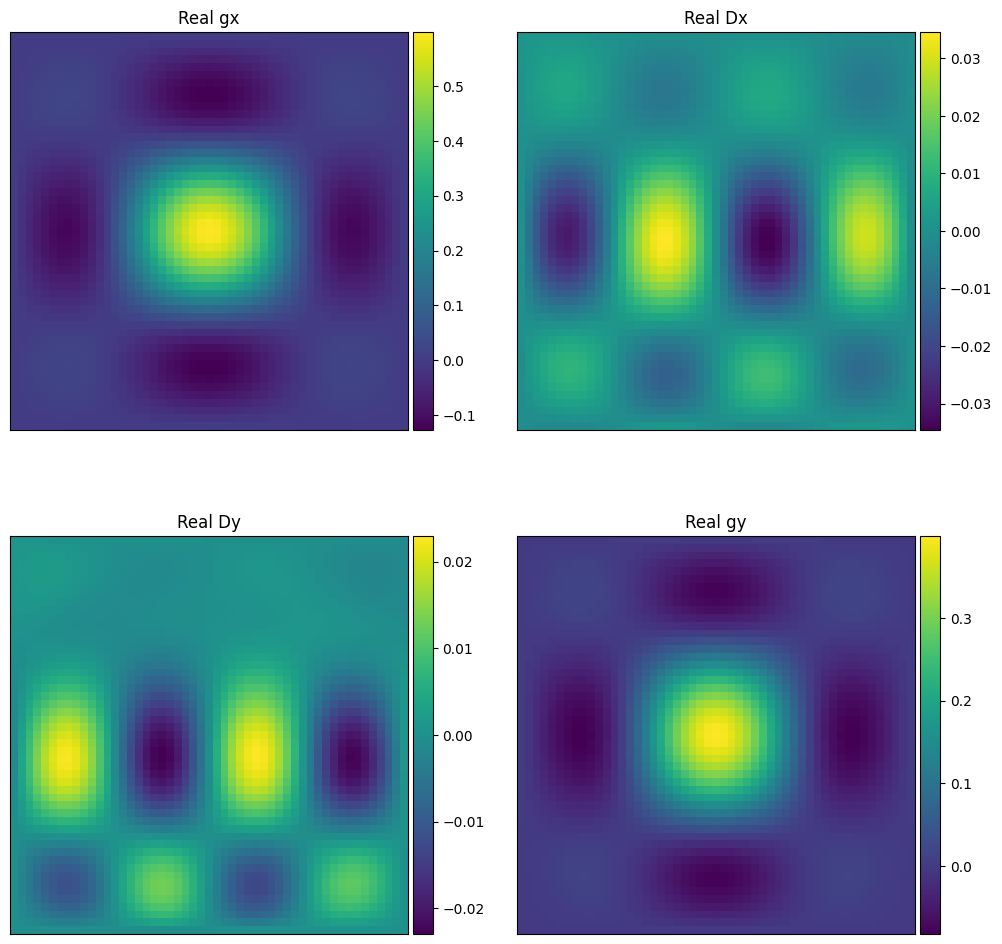

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
0.36000002222043886 0.16000001044474385
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile001t00_f200.040MHz.png
23409 26010
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile001t01_f199.600MHz.png


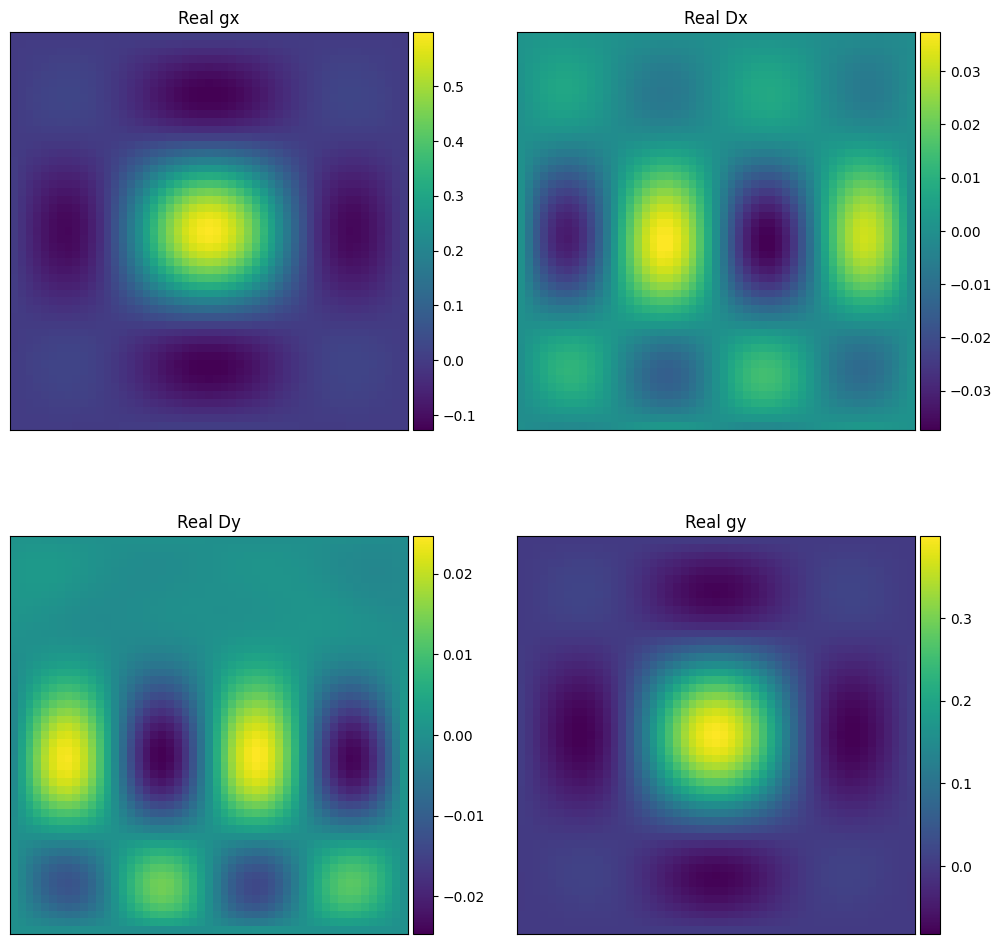

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
0.36000002222043886 0.16000001044474385
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile001t01_f199.600MHz.png
26010 28611
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile001t01_f200.000MHz.png


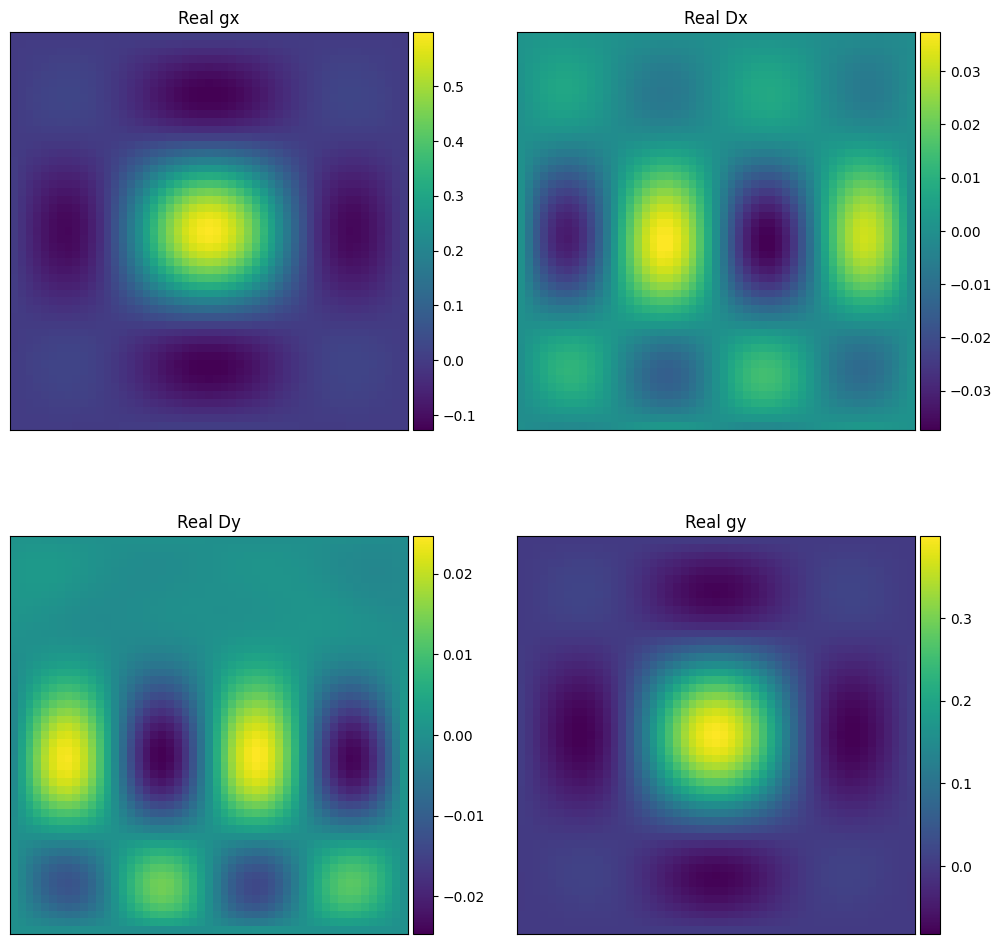

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
0.36000002222043886 0.16000001044474385
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile001t01_f200.000MHz.png
28611 31212
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile001t01_f200.040MHz.png


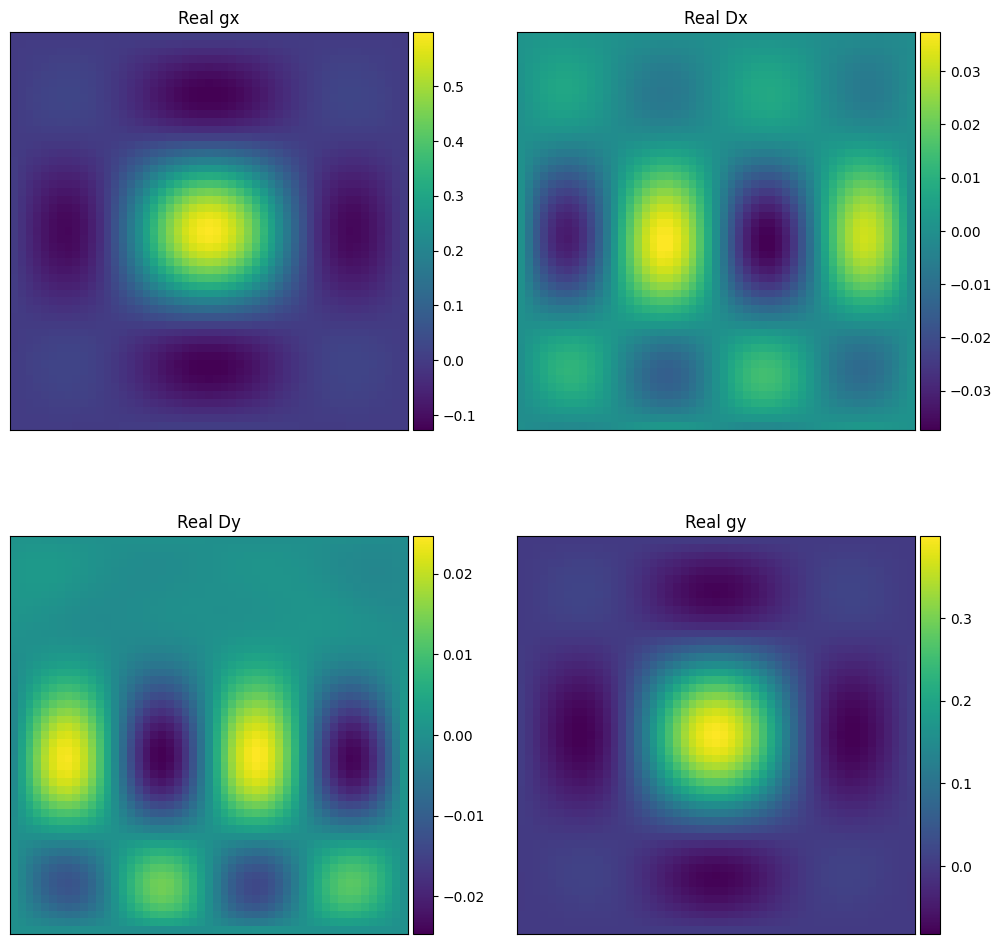

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
0.36000002222043886 0.16000001044474385
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile001t01_f200.040MHz.png
31212 33813
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile002t00_f199.600MHz.png


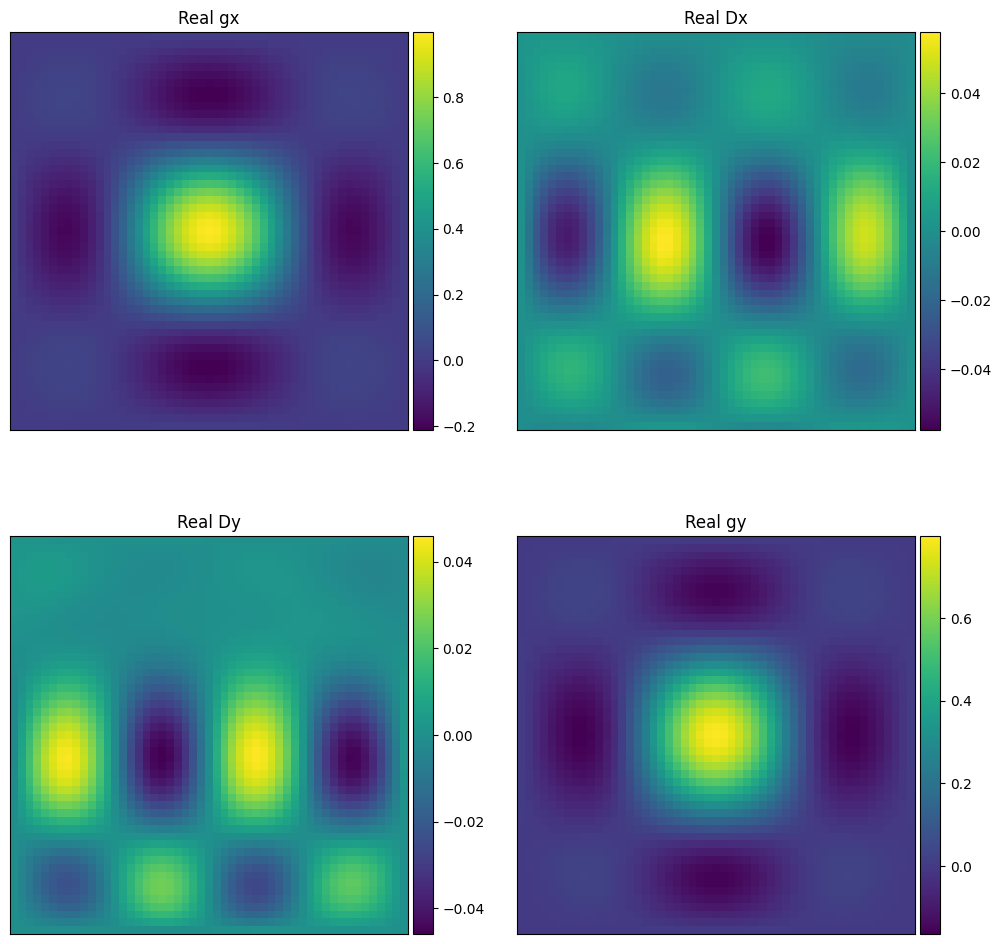

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
1.0000000617233418 0.6400000417789754
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile002t00_f199.600MHz.png
33813 36414
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile002t00_f200.000MHz.png


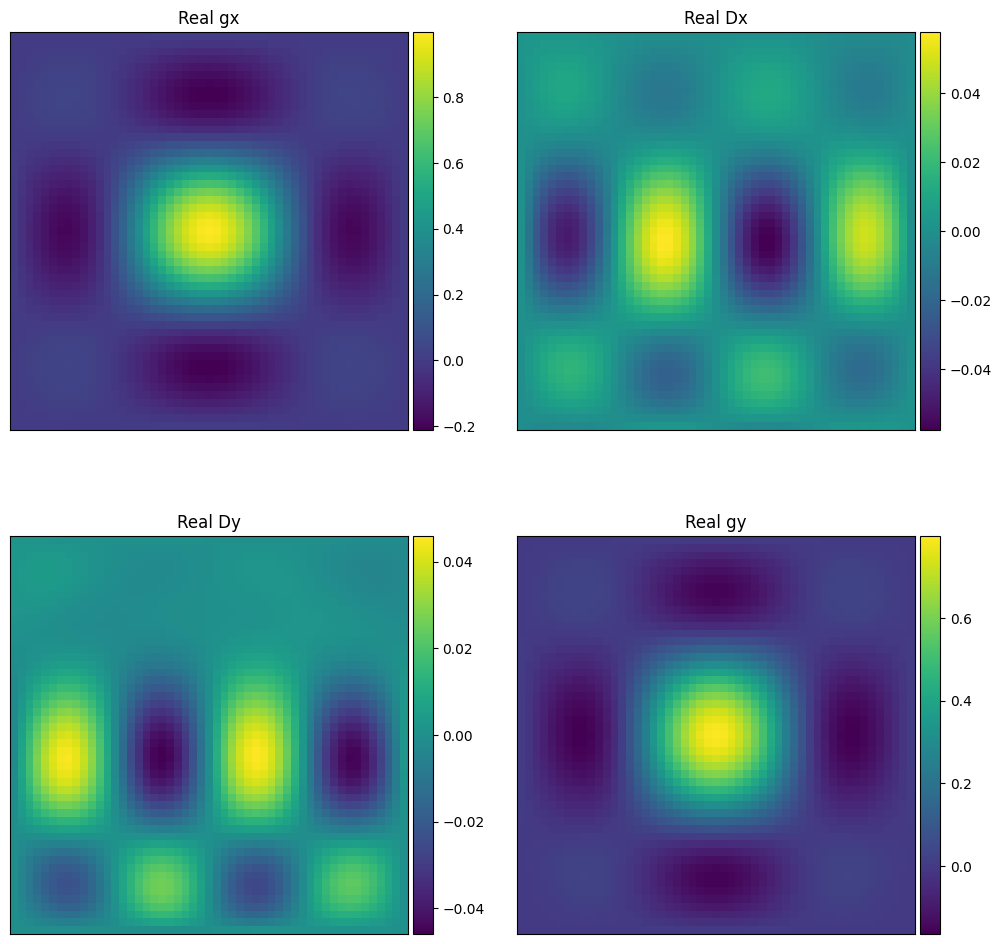

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
1.0000000617233418 0.6400000417789754
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile002t00_f200.000MHz.png
36414 39015
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile002t00_f200.040MHz.png


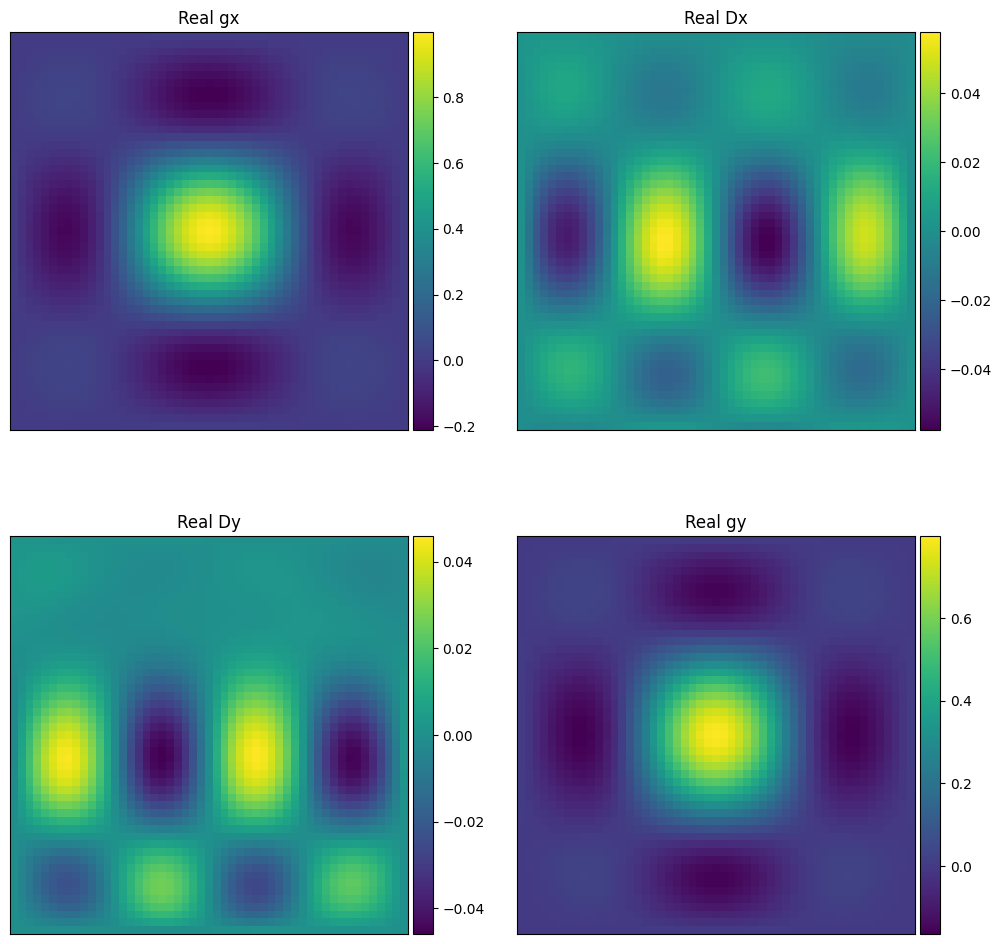

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
1.0000000617233418 0.6400000417789754
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile002t00_f200.040MHz.png
39015 41616
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile002t01_f199.600MHz.png


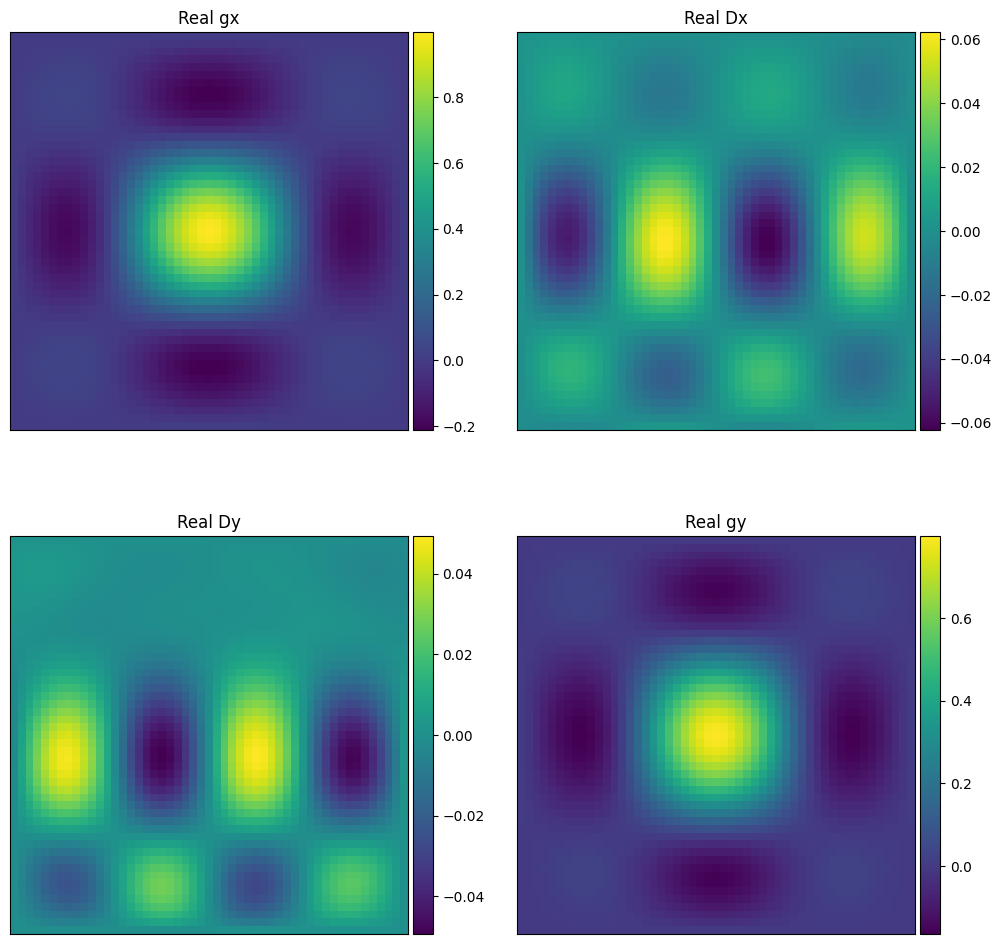

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
1.0000000617233418 0.6400000417789754
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile002t01_f199.600MHz.png
41616 44217
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile002t01_f200.000MHz.png


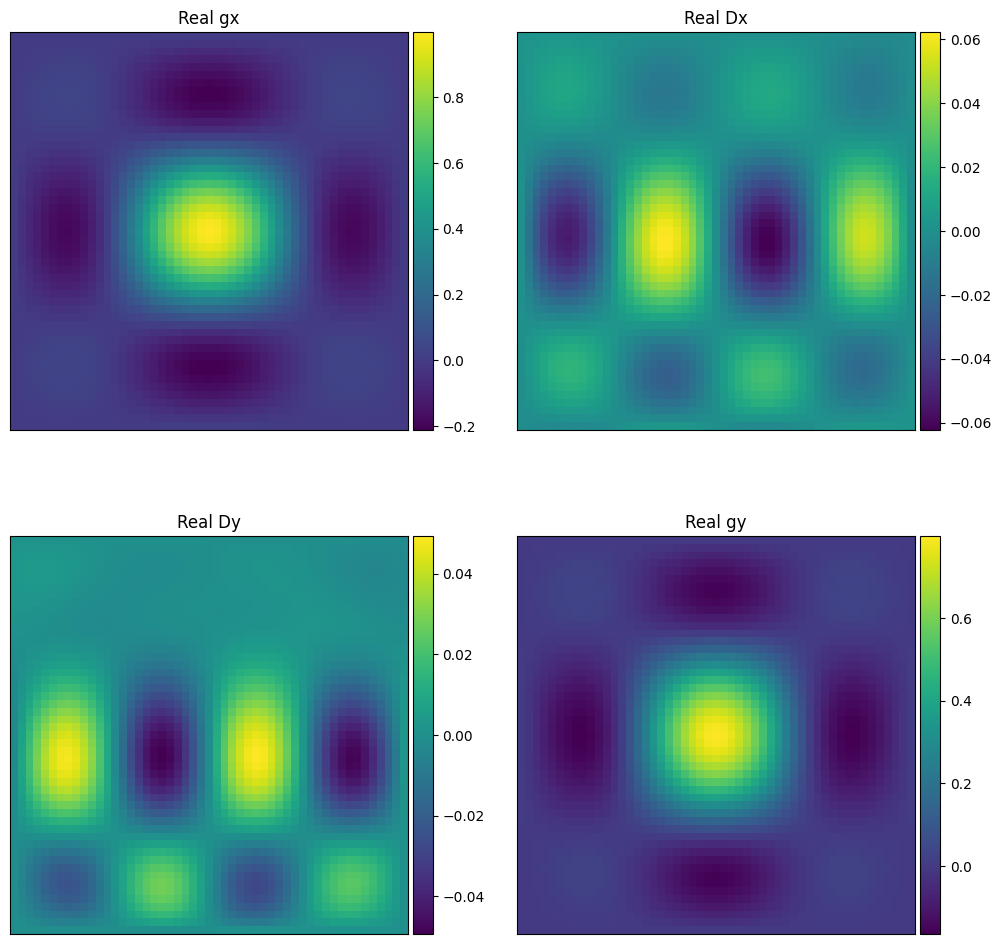

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
1.0000000617233418 0.6400000417789754
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile002t01_f200.000MHz.png
44217 46818
plots/jones_hyperbeam_rot_zenith_multiants_gains_nside51_tile002t01_f200.040MHz.png


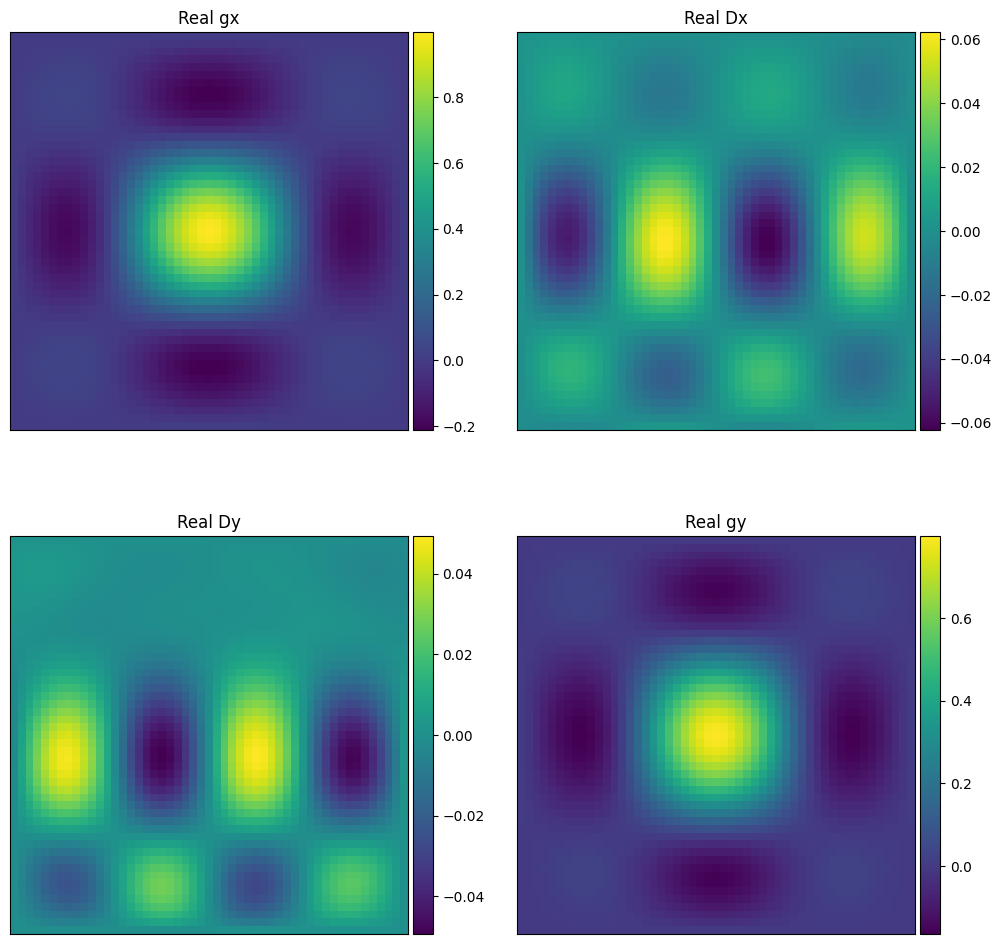

shapes sucka (51, 51) (51, 51) (51, 51) (51, 51)
1.0000000617233418 0.6400000417789754
plots/linear_pol_hyperbeam_rot_zenith_multiants_gains_nside51_tile002t01_f200.040MHz.png


In [5]:
call('mkdir -p plots', shell=True)

for freq in [200e+6]:
    ##Ran code with three very similar freqs, all freqs should
    ##lie withing a frequency band of the model so be identical
    plot_freqs = [freq-40e+4, freq, freq + 40e+3]
    
    for delay_name in ['zenith']:

        filename = f"../../../build/cmake_testing/GPU_or_C_code/primary_beam/hyperbeam_{delay_name}_{int(freq/1e+6)}_multiants_rot_double.txt"
        print(filename)
        azs, zas, gx, Dx, Dy, gy, freqs = load_data(filename)
        plot_jones_square(azs, zas, gx, Dx, Dy, gy, 
                          plot_freqs, filename, 
                          tag=f'hyperbeam_rot_{delay_name}_multiants',
                          num_times=2, num_freqs=3, nside=51, num_tiles=3,
                          limits=False)